<a href="https://colab.research.google.com/github/ecristallini/PolygonalFaults/blob/main/Analiza_Fallas_Poligonales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Caracterización de sistemas de fallas poligonales (SFP) en mapa***

Este código fue desarrollado por [Ernesto Cristallini](https://sites.google.com/site/ecristallini/home) y Margarita Cristallin y tiene como fin caracterizar sistemas de fallas poligonales en base a su geometría en planta. Fue desarrollado en Google Colab (phython 3).

El mapa con las fallas del SFP debe cargarse en *shapefile*. Está pensado para que cada lado de los polígonos esté formado por un solo segmento. Si un lado estuviera formado por varios segmentos, podría haber un sesgo en el cálculo de ángulos y longitudes.



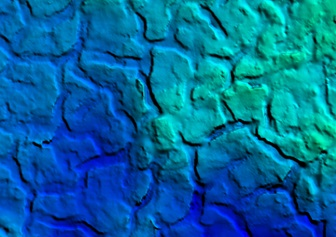

In [ ]:
!pip install mplstereonet

In [ ]:
import numpy as np
import mplstereonet
import math
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString
from pyproj import Transformer
import csv
import folium
from IPython.display import display
from folium.plugins import BeautifyIcon
from google.colab import files





***Importación de mapa en shapefile***

Por favor seleccione los archivos .shp, .shx, .dbf y .prj del mapa que quiere procesar.
El mapa tiene que estar en coordenadas Gauss-Kruger.
Debe contener líneas rectas que representan a los lados de los polígonos del sistema de fallas poligonales.

In [ ]:
!rm * # Elimina todos los archivos
uploaded = files.upload() # Pide al usuario que cargue el archivo SVG
nombre_archivo = list(uploaded.keys())[0] # Obtiene los nombrse de los archivos cargados

#TIENEN QUE SER 4 ARCHIVOS (shp, shx, dbf y prj de lo contrario se producirá un error)


Crea las clases para transformar entre coordenadas geográficas y Gauss Kruger. Si su proyecto estuviera en coordenadas distintas a Gauss-Kruger debería modificar estas dos clases.

In [ ]:
def geograficas_a_posgar(lat, lon):
    transformer = Transformer.from_crs('EPSG:4326', 'EPSG:22182', always_xy=True)
    posgar_x, posgar_y = transformer.transform(lon, lat)
    return posgar_x, posgar_y

In [ ]:
def posgar_a_geograficas(X, Y):
    transformer = Transformer.from_crs('EPSG:22182','EPSG:4326')
    lat, lon = transformer.transform(Y, X)
    return lat, lon

Lee las fallas desde el archivo del mapa.

In [ ]:
fallas=gpd.read_file(nombre_archivo)

Grafica las fallas para visualizar que no haya errores.

In [ ]:
fallas.plot()


Se define la funcion azimut

In [ ]:
def azimuth(point1, point2):
    '''azimuth between 2 shapely points (interval 0 - 360)'''
    angle = np.arctan2(point2.x - point1.x, point2.y - point1.y)
    return np.degrees(angle) if angle >= 0 else np.degrees(angle) + 360

Se calculan los angulos y longitudes de cada segmento de cada falla (las fallas pueden tener uno o más segmentos)

In [ ]:
#Primero se separan los segmentos de adentro de cada falla y se construye una lista de segmentos
segmentos=[]
azimutes=[]
azimutes_pesados=[]
dips=[]
resultado=[]

for f in fallas.geometry:
  coordenadas = list(f.coords)
  puntoAnterior=coordenadas[0]
  for i in range(1,len(coordenadas)):
    segmentos.append(LineString([puntoAnterior, coordenadas[i]]))
    puntoAnterior=coordenadas[i]

#Ahora se calculan los azimutes y longitudes
for s in segmentos:
  l=int(s.length)
  p1=Point(s.coords[0])
  p2=Point(s.coords[1])
  a=azimuth(p1,p2)
  resultado.append([a,l])
  azimutes.append(a)
  for metros in range(0,l):
    azimutes_pesados.append(a)
  dips.append(90)

#La variable azimutes contendra la lista de todos los azimutes
#La variable azimutes_pesados contendra la lista de todos los azimutes repetidos tantas veces como indique su peso en cantidad de metros.
#Es decir si por ejempo hubieran 10 m de falla con azimut 25°, se agregarían 10 azimutes de 25°
#La variable resultados contendra la lista de todos los azimutes y de todos las largos



***Gráfico de rosetas (dirección de las fallas)***

Se calculan el número de direcciones (azimutes) cada 10° para hacer el histograma. Si el gáfico se quiere hacer pesado por longitud debe usarse la variable "azimutes_pesados" si se quiere solo frecuiencia de direcciones debe usarse la variable "azimutes".

In [ ]:
bin_edges = np.arange(-5, 366, 10)
number_of_strikes, bin_edges = np.histogram(azimutes_pesados, bin_edges)

Suma el último valor con el primero.

In [ ]:
number_of_strikes[0] += number_of_strikes[-1]

Asegura datos axiales.

In [ ]:
half = np.sum(np.split(number_of_strikes[:-1], 2), 0)
two_halves = np.concatenate([half, half])

Muestra el gráfico de rosetas

In [ ]:


fig = plt.figure(figsize=(16,8))


ax = fig.add_subplot(122, projection='polar')

ax.bar(np.deg2rad(np.arange(0, 360, 10)), two_halves,
       width=np.deg2rad(10), bottom=0.0, color='.8', edgecolor='k')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0, 360, 10), labels=np.arange(0, 360, 10))

ax.set_title('Distribución angular de fallas poligonales (pesadas por longitud)', y=1.10, fontsize=15)

fig.tight_layout()


***Salva resultados de dirección de fallas para Estereográfica Web***

Salva un archivo con el formato del programa Estereográfica web que se puede utilizar libremente en http://estereo.reyuntec.ar. Allí se pueden personalizar el gráfico de rosetas y exportarlo en formato vectorial (svg)


In [ ]:
nombre_archivo = nombre_archivo+'_Resultados_Estereo.csv'  # Ruta del archivo en tu Google Drive

with open(nombre_archivo, 'w') as archivo:
  texto='Nombre;Azimut;Inclinacion;TipoDato;TipoAzimut;R;G;B;Grosor;EstriaAzi;EstriaIncli;EstriaMov;EstriaRke;Peso'
  archivo.write(texto+ '\n')

  for p in resultado:
    indice=resultado.index(p)
    texto="{:.0f}".format(indice)+';'+"{:.0f}".format(p[0])+';'+'90'+';'+'P'+';'+'0'+';0;128;0;2;0;0;;0;'+"{:.0f}".format(p[1])

    archivo.write(texto+ '\n')


archivo.close()


***Cálculo de ángulo entre fallas***

Aquí se va a calcular el ángulo entre todas las fallas que coalecen en un punto. Para determinar la intersección se utiliza un humbral de 200 m. En en caso de querer cambiarlo se puede modificar la variable "humbral". Esta rutina puede tardar unos minutos dependiendo de la cantidad de fallas involucradas.

In [ ]:
humbral=200 #distancia humbral para calcular ángulos

Calcula el ángulo entre dos azimutes

In [ ]:
def diferenciaAzimutes(a1,a2):
  if a2>a1:
    a2=a2-a1
    if a2<=180:
      return a2
    else:
      return 360-a2
  else:
    a1=a1-a2
    if a1<=180:
      return a1
    else:
      return 360-a1


Calcula el ángulo entre todas las fallas que se juntan en un punto

In [ ]:

angulosRamas=[]


nudosOriginal=[]

for i in range(0,len(segmentos)):
  s0=segmentos[i]
  p1=Point(s0.coords[0])
  p2=Point(s0.coords[1])

  nudosOriginal.append(p1)
  nudosOriginal.append(p2)

  for j in range(0,len(segmentos)):
    if j!=i:
      s1=segmentos[j]
      pp1=Point(s1.coords[0])
      pp2=Point(s1.coords[1])
      a=azimuth(p1,p2)

      if ((p1.x - pp1.x)**2 + (p1.y - pp1.y)**2)**0.5<humbral:
        b=azimuth(pp1,pp2)
        diferencia=diferenciaAzimutes(a,b)
        angulosRamas.append(int(diferencia))

      elif((p1.x - pp2.x)**2 + (p1.y - pp2.y)**2)**0.5<humbral:
        b=azimuth(pp2,pp1)
        diferencia=diferenciaAzimutes(a,b)
        angulosRamas.append(int(diferencia))

      a=azimuth(p2,p1)

      if ((p2.x - pp1.x)**2 + (p2.y - pp1.y)**2)**0.5<humbral:
        b=azimuth(pp1,pp2)
        diferencia=diferenciaAzimutes(a,b)
        angulosRamas.append(int(diferencia))

      elif((p2.x - pp2.x)**2 + (p2.y - pp2.y)**2)**0.5<humbral:
        b=azimuth(pp2,pp1)
        diferencia=diferenciaAzimutes(a,b)
        angulosRamas.append(int(diferencia))



Imprime el número de ángulos para control

In [ ]:
print ('La cantidad de ángulos calculados fue de: ',len(angulosRamas))

***Histograma de angulos entre fallas***

Muestra el histograma de todos los ángulos entre fallas calculados

In [ ]:
fig, bx = plt.subplots()
bin_width = 10
bins = range(min(angulosRamas), max(angulosRamas) + bin_width, bin_width)

bx.hist(angulosRamas, bins=bins, edgecolor = "black")

plt.xlabel('Ángulos')
plt.ylabel('Frecuencia')
plt.title('Angulos entre fallas')

***Largo de fallas***

Se va a calcular el y graficar un histograma con el largo de las fallas

In [ ]:

largos=[]
sumaMediaLong=0
sumaMediaAng=0
for r in resultado:
  largos.append(r[1])
  sumaMediaLong=sumaMediaLong+r[1]
  sumaMediaAng=sumaMediaAng+r[0]

mediaLong=sumaMediaLong/len(largos)
mediaAng=sumaMediaAng/len(largos)

fig, bx = plt.subplots()
# bin_width = 10
# bins = range(min(angulosRamas), max(angulosRamas) + bin_width, bin_width)

bx.hist(largos, edgecolor = "black", color = "orange")

plt.xlabel('Longitudes')
plt.ylabel('Frecuencia')
plt.title('Longitudes de fallas')

***Cálculo de espaciamientos***

Clase para calcular intersecciones

In [ ]:
# intersection between line(p1, p2) and line(p3, p4)
def intersect(p1, p2, p3, p4):
    x1,y1 = p1
    x2,y2 = p2
    x3,y3 = p3
    x4,y4 = p4
    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
    if denom == 0: # parallel
        return None
    ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
    if ua < 0 or ua > 1: # out of range
        return None
    ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
    if ub < 0 or ub > 1: # out of range
        return None
    x = x1 + ua * (x2-x1)
    y = y1 + ua * (y2-y1)
    return (x,y)

In [ ]:
centroide=fallas.dissolve().centroid #calcual el centroide de todos los puntos de todas las fallas.

#calcula los extremos de la zona abarcada por las fallas
xMax=fallas.total_bounds[2]
xMin=fallas.total_bounds[0]
yMax=fallas.total_bounds[3]
yMin=fallas.total_bounds[1]


Calcula 1000 scanlines EW como para computar el espaciamiento EW. Se puede cambiar el número de scanlines cambiando en el for el número.

In [ ]:
espaciamientoEW=[]

for i in range(int(yMin),int(yMax),1000):
  p1=(xMin,i)
  p2=(xMax,i)
  interMinX=999999999
  interMaxX=-999999999
  numerInter=0
  for f in fallas.geometry:
    coordenadas = list(f.coords)
    p3=coordenadas[0]
    p4=coordenadas[1]
    inter=intersect(p1,p2,p3,p4)
    if inter is not None:
      numerInter=numerInter+1
      if inter[0]<interMinX:
        interMinX=inter[0]
      if inter[0]>interMaxX:
        interMaxX=inter[0]

  if numerInter>1:
    espaciamiento=(interMaxX-interMinX)/(numerInter-1)
    espaciamientoEW.append(espaciamiento)




Calcula 1000 scanlines NS como para computar el espaciamiento NS. Se puede cambiar el número de scanlines cambiando en el for el número.

In [ ]:
espaciamientoNS=[]
for i in range(int(xMin),int(xMax),1000):
  p1=(i,yMin)
  p2=(i,yMax)
  interMinY=999999999
  interMaxY=-999999999
  numerInter=0
  for f in fallas.geometry:
    coordenadas = list(f.coords)
    p3=coordenadas[0]
    p4=coordenadas[1]
    inter=intersect(p1,p2,p3,p4)
    if inter is not None:
      numerInter=numerInter+1
      if inter[1]<interMinY:
        interMinY=inter[1]
      if inter[1]>interMaxY:
        interMaxY=inter[1]


  if numerInter>1:
    espaciamiento=(interMaxY-interMinY)/(numerInter-1)
    espaciamientoNS.append(espaciamiento)


Grafica el histograma de espaciamiento EW

In [ ]:
fig, bx = plt.subplots()
# bin_width = 10
# bins = range(min(angulosRamas), max(angulosRamas) + bin_width, bin_width)

bx.hist(espaciamientoEW, edgecolor = "black", color = "orange")

plt.xlabel('Espaciamiento W-E')
plt.ylabel('Frecuencia')
plt.title('Espaciamiento')

Grafica el histograma de espaciamiento EW

In [ ]:
fig, bx = plt.subplots()
# bin_width = 10
# bins = range(min(angulosRamas), max(angulosRamas) + bin_width, bin_width)

bx.hist(espaciamientoNS, edgecolor = "black", color = "orange")

plt.xlabel('Espaciamiento N-S')
plt.ylabel('Frecuencia')
plt.title('Espaciamiento')

***Calcula el área característica***

El área característica no se mide. Se calcula suponiendo que el patrón de fallas es hexagonal. Se calcula el área que tendría un hexágono regular que tenga como longitud de lados el largo medio de fallas calculado.

In [ ]:

apotema=np.sqrt(mediaLong**2-(0.5*mediaLong)**2)

perimetro=6*mediaLong
area=perimetro*apotema/2




***Se muestran los resultados medios***

Se muestran el largo medio de fallas, el área característica y el

In [ ]:
print ('Media de largos= ',"{:.0f}".format(mediaLong),'m')

print ('Area= ',"{:.2f}".format(area/1000000),' km2')
print ('Media de direcciones= ',"{:.0f}".format(mediaAng),'°')


sumaMediaAngulo_interfalla=0
for a in angulosRamas:
  sumaMediaAngulo_interfalla=sumaMediaAngulo_interfalla+a

media_angulo_interfalla=sumaMediaAngulo_interfalla/len(angulosRamas)

print ('Media de angulos entre fallas= ',"{:.0f}".format(media_angulo_interfalla),'°')
